In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hw6.ipynb")

# CPSC 330 - Applied Machine Learning 

## Homework 6: Clustering
### Associated lectures: [Lectures 15 and 16](https://github.com/UBC-CS/cpsc330-2023s/tree/main/lectures)

**Due date: See the [Calendar](https://htmlpreview.github.io/?https://github.com/UBC-CS/cpsc330-2023s/blob/master/docs/calendar.html).**

## Imports <a name="im"></a>

In [2]:
import os
from hashlib import sha1

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN, KMeans
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline
pd.set_option("display.max_colwidth", 0)

<br><br><br><br>

## Submission instructions <a name="si"></a>
<hr>
rubric={points:2}

You will receive marks for correctly submitting this assignment. To submit this assignment, follow the instructions below:

- **You may work on this assignment in a group (group size <= 4) and submit your assignment as a group.** 
- Below are some instructions on working as a group.  
    - The maximum group size is 4. 
    - You can choose your own group members. 
    - Use group work as an opportunity to collaborate and learn new things from each other. 
    - Be respectful to each other and make sure you understand all the concepts in the assignment well. 
    - It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. [Here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members) are some instructions on adding group members in Gradescope.  
- Be sure to follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330-2023s/blob/main/docs/homework_instructions.md).
- Upload the .ipynb file to Gradescope.
- **If the .ipynb file is too big or doesn't render on Gradescope for some reason, also upload a pdf or html in addition to the .ipynb.** 
- Make sure that your plots/output are rendered properly in Gradescope.

In [3]:
import numpy as np
np.random.randint(100, 10_000)

6472

<br><br><br><br>

## Exercise 1: Document clustering warm-up
<hr>

In this homework, we will explore a popular application of clustering called [**document clustering**](https://en.wikipedia.org/wiki/Document_clustering). A large amount of unlabeled text data is available out there (e.g., news, recipes, online Q&A, tweets), and clustering is a commonly used technique to organize this data in a meaningful way. 

As a warm up, in this exercise, you will cluster sentences from a toy corpus. Later in the homework, you will work with a real corpus. 

The code below extracts introductory sentences of Wikipedia articles on a set of queries. To run the code successfully, you will need the `wikipedia` package installed in the course environment. 

```
conda activate cpsc330
conda install -c conda-forge wikipedia
```


**Your tasks:**

Run the code below which 
- extracts content of Wikipedia articles on a set of queries
- tokenizes the text (i.e., separates sentences) and 
- stores the 2nd sentence in each article as a document representing that article

> Feel free to experiment with Wikipedia queries of your choice. But stick to the provided list for the final submission so that it's easier for the TAs to grade your submission.

> For tokenization we are using the `nltk` package. If you do not have this package in the course environment, you will have to install it.

```
conda activate cpsc330
conda install -c anaconda nltk
```

Even if you have the package installed via the course `conda` environment, you might have to download `nltk` pre-trained models, which can be done with the code below.

In [4]:
import nltk

nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ryanm\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
import wikipedia
from nltk.tokenize import sent_tokenize, word_tokenize

queries = [
    "hummus food",
    "bread food",
    "artificial intelligence",
    "unsupervised learning",
    "football sport",
    "ice hockey",
]

wiki_dict = {"wiki query": [], "text": [], "n_words": []}
for i in range(len(queries)):
    text = sent_tokenize(wikipedia.page(queries[i]).content)[1]
    wiki_dict["text"].append(text)
    wiki_dict["n_words"].append(len(word_tokenize(text)))
    wiki_dict["wiki query"].append(queries[i])

wiki_df = pd.DataFrame(wiki_dict)
wiki_df

,wiki query,text,n_words
0,hummus food,"The standard garnish in the Middle East includes olive oil, a few whole chickpeas, parsley, and paprika.Popular in Middle Eastern cuisine, it is usually eaten as a dip, with pita bread.",37
1,bread food,"Throughout recorded history and around the world, it has been an important part of many cultures' diet.",20
2,artificial intelligence,"Example tasks in which this is done include speech recognition, computer vision, translation between (natural) languages, as well as other mappings of inputs.AI applications include advanced web search engines (e.g., Google Search), recommendation systems (used by YouTube, Amazon, and Netflix), understanding human speech (such as Siri and Alexa), self-driving cars (e.g., Waymo), generative or creative tools (ChatGPT and AI art), automated decision-making, and competing at the highest level in strategic game systems (such as chess and Go).As machines become increasingly capable, tasks considered to require ""intelligence"" are often removed from the definition of AI, a phenomenon known as the AI effect.",134
3,unsupervised learning,"The goal of supervised learning algorithms is learning a function that maps feature vectors (inputs) to labels (output), based on example input-output pairs.",29
4,football sport,"Sports can, through casual or organized participation, improve participants' physical health.",15
5,ice hockey,It belongs to a family of sports called hockey.,10


Our toy corpus has six toy documents (`text` column in the dataframe) extracted from Wikipedia queries. 

<br><br>

<!-- BEGIN QUESTION -->

### 1.1 How many clusters? 
rubric={points:1}


**Your tasks:**

1. If you are asked to cluster the documents from this toy corpus manually, how many clusters would you identify and how would you label each cluster?   

<div class="alert alert-warning">

Solution_1.1
    
</div>

_Points:_ 1

I would make 3 clusters:
- Food: hummus food, bread food
- Computer science: artificial intelligence, unsupervised learning
- Sports: football sport, ice hockey

<!-- END QUESTION -->

<br><br>

### 1.2 `KMeans` with bag-of-words representation 
rubric={autograde:3}

Before we pass text to machine learning models, we need to encode it to a numeric representation. We will try two representations: bag-of-words representation and sentence embedding representation. First, let's try our good old friend, bag-of-words.

**Your tasks:**

1. Create bag-of-words representation using [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) with `stop_words='english'` for the `text` column in `wiki_df` above. Store the representation in `transformed`.
2. Cluster the documents with this representation and [`KMeans` clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) with the following arguments: 
    - `random_state=42` (for reproducibility)
    - `n_clusters`=the number of clusters you identified in 1.1
3. Store the labels as a list in `kmeans_labels`

<div class="alert alert-warning">

Solution_1.2
    
</div>

_Points:_ 3

In [6]:
countvec = CountVectorizer(stop_words="english")
transformed = countvec.fit_transform(wiki_df["text"])

transformed

<6x107 sparse matrix of type '<class 'numpy.int64'>'
	with 110 stored elements in Compressed Sparse Row format>

In [7]:
kmeans_wiki = KMeans(n_clusters = 3, random_state = 42)
kmeans_wiki.fit(transformed)
kmeans_labels = kmeans_wiki.labels_.tolist()
kmeans_pred = kmeans_wiki.predict(transformed)

In [8]:
grader.check("q1.2")

q1.2 results: All test cases passed!

<br><br>

### 1.3 Sentence embedding representation
rubric={autograde:3}

As we have seen before, bag-of-words representation is limited in that it does not take into account word ordering and context. There are other richer and more expressive representations of text, and we are going to use one such representation in this homework. We will call it **sentence embedding representation**. We'll use [sentence transformer](https://www.sbert.net/index.html) to extract these representations. At this point it's enough to know that this is an alternative representation of text which usually works better than simple bag-of-words representation. We will talk a bit more about embedding representations in the coming weeks. To use sentence transformer, you need to install `sentence-transformers` in the course conda environment to run the code below. 

```conda install -c conda-forge sentence-transformers```


**Your tasks:**

1. Run the code below to create sentence embedding representation of documents in our toy corpus. 
2. Cluster the documents with this representation (`emb_sents`) and `KMeans` with the following arguments: 
    - `random_state=42` (for reproducibility)
    - `n_clusters`=the number of clusters you identified in 1.1
3. Store the labels as a list in `kmeans_emb_labels`

In [9]:
from sentence_transformers import SentenceTransformer

embedder = SentenceTransformer("paraphrase-distilroberta-base-v1")

In [10]:
emb_sents = embedder.encode(wiki_df["text"])
emb_sent_df = pd.DataFrame(emb_sents, index=wiki_df.index)
emb_sent_df

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.071856,0.355502,0.030290,0.177983,0.369931,-0.032932,-0.009006,-0.238870,0.057462,0.222121,...,0.161689,-0.030927,0.368840,0.128081,0.107281,-0.057393,0.515434,0.348882,0.038445,-0.162513
1,-0.022417,0.217159,0.022693,0.003616,0.240856,0.358047,-0.053310,-0.328075,0.190012,0.244470,...,0.265413,-0.415595,0.003036,0.052484,0.345947,0.110091,0.405441,0.197792,-0.058253,0.212376
2,0.138657,0.334279,0.152657,-0.190610,0.329723,-0.086983,0.078042,0.223038,0.063345,0.000502,...,0.049124,0.164720,-0.034465,-0.063466,0.057811,-0.059856,0.352751,-0.268579,-0.081088,0.066146
3,0.282049,0.158558,-0.077177,0.413478,0.351787,0.478120,0.079723,0.468191,0.249393,-0.071113,...,0.231550,-0.038059,0.144132,-0.124127,-0.003824,-0.016014,0.590400,0.028412,0.268744,0.024894
4,0.401522,0.294518,0.169535,0.092036,0.159018,0.504919,0.392199,-0.074318,0.314625,0.033591,...,0.362093,-0.135944,0.133036,0.353604,-0.222302,0.077625,-0.082624,0.261560,0.272954,0.113218
5,0.108902,0.087364,0.119847,-0.050133,0.240210,-0.082101,0.190988,0.436203,-0.085558,-0.012788,...,0.145414,0.160032,0.071931,0.147640,0.043789,0.253031,-0.009358,0.415206,0.142142,0.130365


<div class="alert alert-warning">

Solution_1.3
    
</div>

_Points:_ 3

In [11]:
kmeans_emb = KMeans(n_clusters=3, random_state=42)
kmeans_emb.fit(emb_sent_df)
kmeans_emb_labels = kmeans_emb.labels_.tolist()
kmeans_emb_pred = kmeans_emb.predict(emb_sent_df)


C:\Users\ryanm\.conda\envs\cpsc330\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [12]:
grader.check("q1.3")

q1.3 results: All test cases passed!

<br><br>

<!-- BEGIN QUESTION -->

### 1.4 DBSCAN with cosine distance  
rubric={points:4}

Let's try [`DBSCAN`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) on our toy dataset. K-Means is kind of bound to the Euclidean distance because it is based on the notion of means. With `DBSCAN` we can try different distance metrics. In the context of text, [cosine similarities](https://scikit-learn.org/stable/modules/metrics.html#cosine-similarity) or cosine distances tend to work better. Given vectors $u$ and $v$, the **cosine distance** between the vectors is defined as: 

$$distance_{cosine}(u,v) = 1 - (\frac{u \cdot v}{\left\lVert u\right\rVert_2 \left\lVert v\right\rVert_2})$$


**Your tasks:**

1. Cluster documents in our toy corpus encoded with sentence embedding representation (`emb_sents`) and [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html?highlight=dbscan#sklearn.cluster.DBSCAN) with `metric='cosine'`. 

> *Note: You will have to set appropriate values for the hyperparameters `eps` and `min_samples` to get meaningful clusters, as default values for these hyperparameters are unlikely to work on this toy dataset.*

<div class="alert alert-warning">

Solution_1.4
    
</div>

_Points:_ 4

In [13]:
dbs = DBSCAN(eps=0.7, metric="cosine", min_samples=1)
dbs_pred = dbs.fit_predict(emb_sents)

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.5 Discussion
rubric={points:4}

**Your tasks:**

1. Reflect and comment on the clusters identified by each of the methods you explored in 1.2, 1.3, and 1.4. Are these methods doing a reasonable job in clustering the sentences in our toy corpus? Do the clustering results change with the representation you use?  

<div class="alert alert-warning">

Solution_1.5
    
</div>

_Points:_ 4

Each of the methods are returning different cluster configurations.  When analyzing the predictions, sentence embedding returns the exact clusters I would create manually, DBSCAN is very close, and KMeans is far off.  It is difficult to say whether they're doing a reasonable job due to the small amount of text in each text box, which limits the possibility of common words, but it seems that sentence embedding and DBSCAN are doing well while KMeans is not.  In terms of representation, it seems that sentence embedding is performing much better than BOW representation for this data set.

<!-- END QUESTION -->

<br><br>

<br><br>

<!-- BEGIN QUESTION -->

### 1.6 Visualizing clusters
rubric={points:3}

One thing we can do with unlabeled data is visualizing it. That said, our data is high dimensional and high-dimensional data is hard to visualize. For example, in sentence embedding representation, each example is represented with 768 dimensions. One way to visualize high-dimensional data is by applying dimensionality reduction to get the most important (2 or 3) components of the dataset and visualizing this low-dimensional data. 

Given data as a `numpy` array and corresponding cluster assignments, the `plot_umap_clusters` function below transforms the data by applying dimensionality reduction technique called [UMAP](https://umap-learn.readthedocs.io/en/latest/) to it and plots the transformed data with different colours for different clusters. 

> *Note: At this point we are using this function only for visualization and you are not expected to understand the UMAP part.* 

You'll have to install the `umap-learn` package in the course conda environment either with `conda` or `pip`, as described in the [documentation](https://umap-learn.readthedocs.io/en/latest/index.html). 

```
> conda activate cpsc330
> conda install -c conda-forge umap-learn
```

or 

```
> conda activate cpsc330
> pip install umap-learn
```

**Your tasks:**

1. Visualize the clusters created by the three methods above using `plot_umap_clusters` function below:
    - KMeans with bag-of-words representation 
    - KMeans with sentence embedding representation
    - DBSCAN with sentence embedding representation  

In [14]:
import umap

C:\Users\ryanm\.conda\envs\cpsc330\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\ryanm\.conda\envs\cpsc330\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\ryanm\.conda\envs\cpsc330\lib\site-packages\umap\distances.py:1086: NumbaDeprecatio

In [15]:
def plot_umap_clusters(
    data,
    cluster_labels,
    raw_sents=wiki_df["text"],
    show_labels=False,
    size=50,
    n_neighbors=15,
    title="UMAP visualization",
    ignore_noise=False,
):
    """
    Carry out dimensionality reduction using UMAP and plot 2-dimensional clusters.

    Parameters
    -----------
    data : numpy array
        data as a numpy array
    cluster_labels : list
        cluster labels for each row in the dataset
    raw_sents : list
        the original raw sentences for labeling datapoints
    show_labels : boolean
        whether you want to show labels for points or not (default: False)
    size : int
        size of points in the scatterplot
    n_neighbors : int
        n_neighbors hyperparameter of UMAP. See the documentation.
    title : str
        title for the visualization plot

    Returns
    -----------
    None. Shows the clusters.
    """

    reducer = umap.UMAP(n_neighbors=n_neighbors, random_state=42)
    Z = reducer.fit_transform(data)  # reduce dimensionality
    umap_df = pd.DataFrame(data=Z, columns=["dim1", "dim2"])
    umap_df["cluster"] = cluster_labels

    if ignore_noise:
        umap_df = umap_df[umap_df["cluster"] != -1]

    labels = np.unique(umap_df["cluster"])

    fig, ax = plt.subplots(figsize=(10, 7))
    ax.set_title(title)

    scatter = ax.scatter(
        umap_df["dim1"],
        umap_df["dim2"],
        c=umap_df["cluster"],
        cmap="tab20b",
        s=size,
        edgecolors="k",
        linewidths=0.1,
    )

    legend = ax.legend(*scatter.legend_elements(), loc="best", title="Clusters")
    ax.add_artist(legend)

    if show_labels:
        x = umap_df["dim1"].tolist()
        y = umap_df["dim2"].tolist()
        for i, txt in enumerate(raw_sents):
            ax.annotate(" ".join(txt.split()[:10]), (x[i], y[i]))
    plt.show()

<div class="alert alert-warning">

Solution_1.4
    
</div>

_Points:_ 3

C:\Users\ryanm\.conda\envs\cpsc330\lib\site-packages\umap\umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


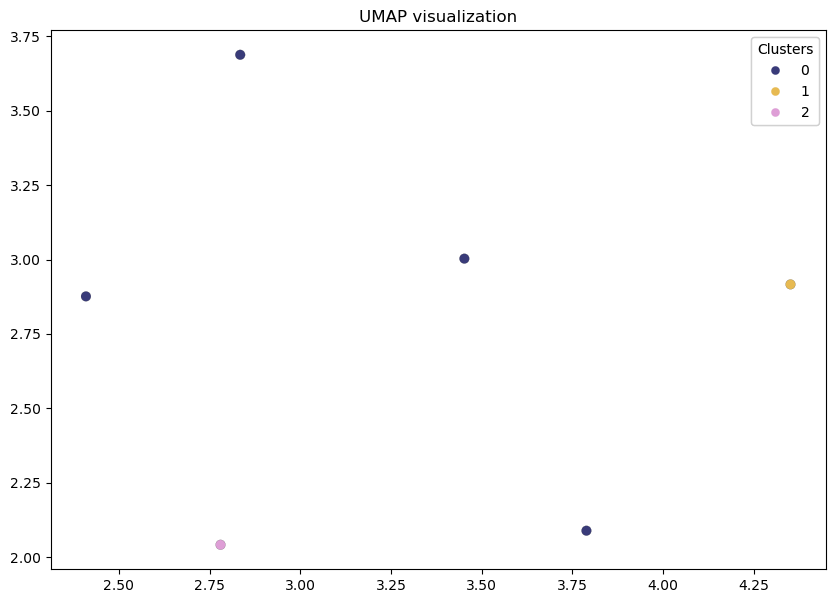

In [16]:
plot_umap_clusters(transformed, kmeans_pred)

C:\Users\ryanm\.conda\envs\cpsc330\lib\site-packages\umap\umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


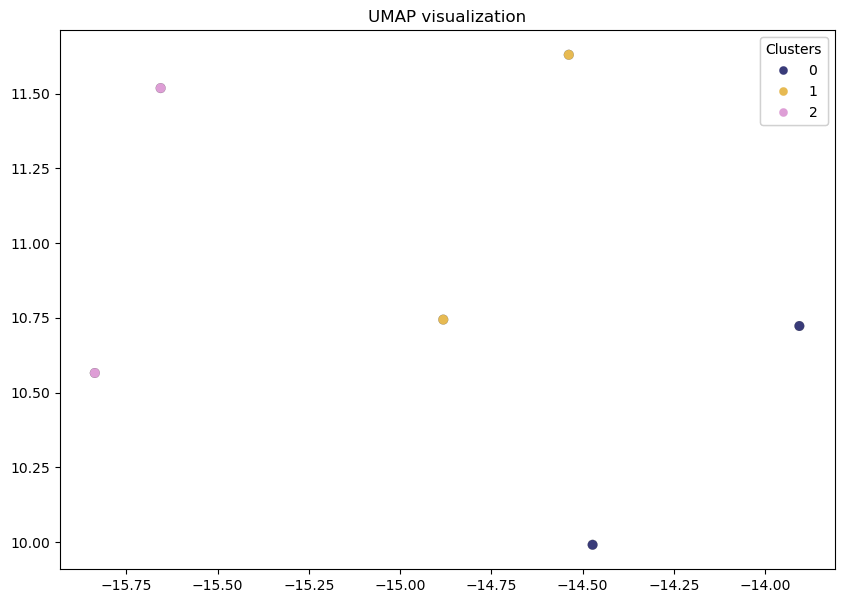

In [17]:
plot_umap_clusters(emb_sents, kmeans_emb_pred)


C:\Users\ryanm\.conda\envs\cpsc330\lib\site-packages\umap\umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


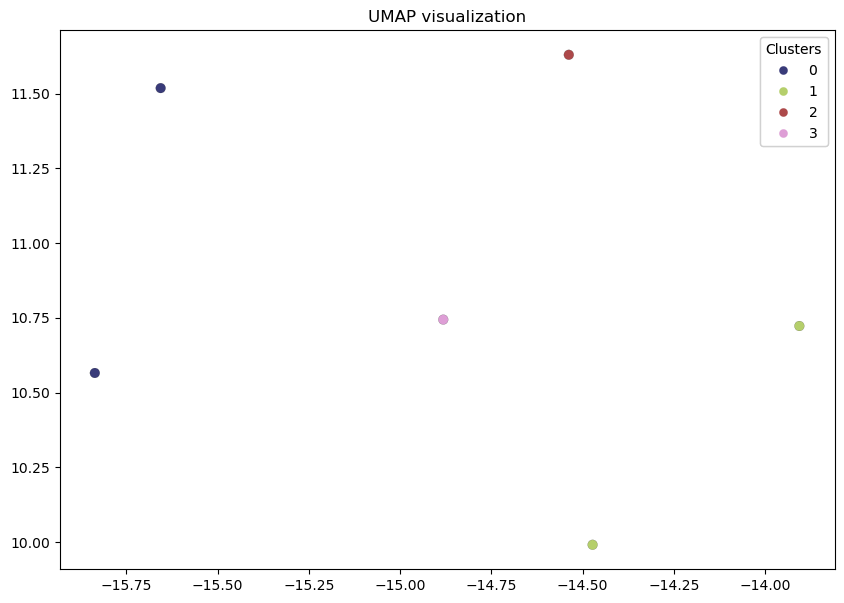

In [18]:
plot_umap_clusters(emb_sents, dbs_pred)


<!-- END QUESTION -->

<br><br><br><br>

## Exercise 2: [Food.com](https://www.food.com/) recipes 
<hr>

Now that we have applied document clustering on a toy dataset, let's cluster sentences from a real corpus. In this lab we will work with a sample of [Kaggle's Food.com recipes corpus](https://www.kaggle.com/shuyangli94/food-com-recipes-and-user-interactions). This corpus contains 180K+ recipes and 700K+ recipe reviews. In this homework, we'll only focus on recipes and **not** on recipe reviews. The recipes are present in `RAW_recipes.csv`. Our goal is to find main categories or groupings of recipes based on their names. 

**Your tasks:**
- Download [`RAW_recipes.csv`](https://www.kaggle.com/shuyangli94/food-com-recipes-and-user-interactions?select=RAW_recipes.csv) and put it in the homework folder under the data folder. As usual, do not push the CSV in your repository. 
- Run the code below. The dataset is quite large, and in this assignment, for speed, you will work with a sample of the dataset. The function `get_recipes_sample` below carries out some preliminary preprocessing and returns a sample of the recipes with most frequent tags. 

> *Note: Depending upon the capacity of your computer, feel free to increase or decrease the size of this sample by changing the value for `n_tags`.* 

In [19]:
orig_recipes_df = pd.read_csv("data/RAW_recipes.csv")
orig_recipes_df.shape

(231637, 12)

In [20]:
def get_recipes_sample(orig_recipes_df, n_tags=300, min_len=5):
    orig_recipes_df = orig_recipes_df.dropna()  # Remove rows with NaNs.
    orig_recipes_df = orig_recipes_df.drop_duplicates(
        "name"
    )  # Remove rows with duplicate names.
    # Remove rows where recipe names are too short (< 5 characters).
    orig_recipes_df = orig_recipes_df[orig_recipes_df["name"].apply(len) >= min_len]
    # Only consider the rows where tags are one of the most frequent n tags.
    first_n = orig_recipes_df["tags"].value_counts()[0:n_tags].index.tolist()
    recipes_df = orig_recipes_df[orig_recipes_df["tags"].isin(first_n)]
    return recipes_df

In [21]:
recipes_df = get_recipes_sample(orig_recipes_df)
recipes_df.shape

(9100, 12)

In [22]:
recipes_df["name"]

42        i yam what i yam  muffins    
101       to your health  muffins      
129       250 00 chocolate chip cookies
138       lplermagronen                
163       california roll   salad      
                   ...                 
231430    zucchini wheat germ cookies  
231514    zucchini blueberry bread     
231547    zucchini salsa burgers       
231596    zuppa toscana                
231629    zydeco salad                 
Name: name, Length: 9100, dtype: object

<br><br>

**In the rest of the homework, we will use `recipes_df` above, which is a subset of the original dataset.** 

<br><br>

### 2.1 Longest and shorted recipe names 
rubric={autograde:2}

**Your tasks:**

1. Print the shortest and longest recipe names (length in terms of number of characters) from `recipes_df`. If there is more than one recipe with the same shortest/longest length, store **one** in `shortest_recipe` and/or `longest_recipe` as a **string**.

<div class="alert alert-warning">

Solution_2.1
    
</div>

_Points:_ 2

In [23]:
shortest_idx = recipes_df['name'].str.len().idxmin()
shortest_recipe = recipes_df.loc[shortest_idx, 'name']
longest_idx = recipes_df['name'].str.len().idxmax()
longest_recipe = recipes_df.loc[longest_idx, 'name']

shortest_recipe, longest_recipe

('bread', 'baked tomatoes with a parmesan cheese crust and balsamic drizzle')

In [24]:
grader.check("q2.1")

q2.1 results: All test cases passed!

<br><br>

<!-- BEGIN QUESTION -->

### 2.2 More EDA
rubric={points:2}

**Your tasks:**
1. Create a word cloud for the recipe names. You can use [the `wordcloud` package](https://github.com/amueller/word_cloud) for this, which you will have to install in the course environment. 

```
> conda activate cpsc330
> conda install -c conda-forge wordcloud
```

<div class="alert alert-warning">

Solution_2.2
    
</div>

_Points:_ 2

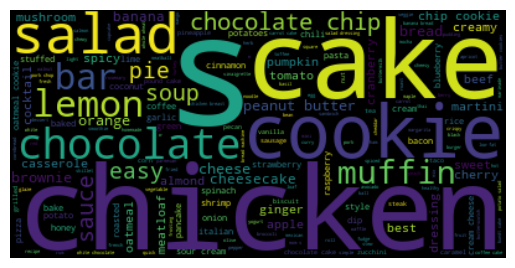

<Figure size 640x480 with 0 Axes>

In [25]:
from wordcloud import WordCloud

all_names = " ".join(recipes_df["name"])
wordcloud = WordCloud().generate(all_names)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.figure()
plt.show()

### 2.3 Representing recipe names
rubric={autograde:3}

The next step is creating a representation of recipe names. 

**Your tasks:**

1. Similar to Exercise 1, create sentence embedding representation of recipe names (`name` column in `recipes_df`).  For the rest of the homework, we'll stick to the sentence embedding representation of recipe names.



> *If you create a dataframe with sentence embedding representation, set the index to `recipes_df.index` so that the indices match with the indices of the sample we are working with.*  
> *This might take a while to run.*

<div class="alert alert-warning">

Solution_2.3
    
</div>

_Points:_ 3

In [26]:
# sents = embedder.encode(recipes_df["name"].tolist())
# embeddings = pd.DataFrame(sents, index=recipes_df.index).to_numpy()

In [27]:
# from Yegor's comment in @383 on Piazza
# load numpy array from csv file
from numpy import loadtxt
# load array
embeddings = loadtxt('data/embeddings.csv', delimiter=',')

In [28]:
grader.check("q2.3")

q2.3 results: All test cases passed!

<br><br><br><br>

## Exercise 3: K-Means on Food.com recipe names

<!-- BEGIN QUESTION -->

### 3.1 Choosing K for K-Means
rubric={points:6}

For K-Means you need to specify the number of clusters in advance, which is often challenging to do on real datasets. As we saw in the lecture, there is no definitive method to select the number of clusters. That said, there are some approaches which may help us with this process. In this exercise, you'll explore three such approaches. 

**Your tasks:**

1. Consider a reasonable range of K (`n_clusters`) values and visualize the Elbow plot. 
2. Consider a reasonable range of K (`n_clusters`) and visualize the clusters created by K-Means by using `plot_umap_clusters` function from Exercise 1. 

> You may use the [`yellowbrick`](https://www.scikit-yb.org/en/latest/) package for visualizing the Elbow plot.   

```
pip install yellowbrick
```

> The range of K or `n_clusters` values does not have to be the same in the cases above. 

> Use the default value of `show_labels=False` when you call function `plot_umap_clusters`, as we do not want to display labels of thousands of data points.    

<div class="alert alert-warning">

Solution_3.1
    
</div>

_Points:_ 3

In [29]:
# !pip install yellowbrick

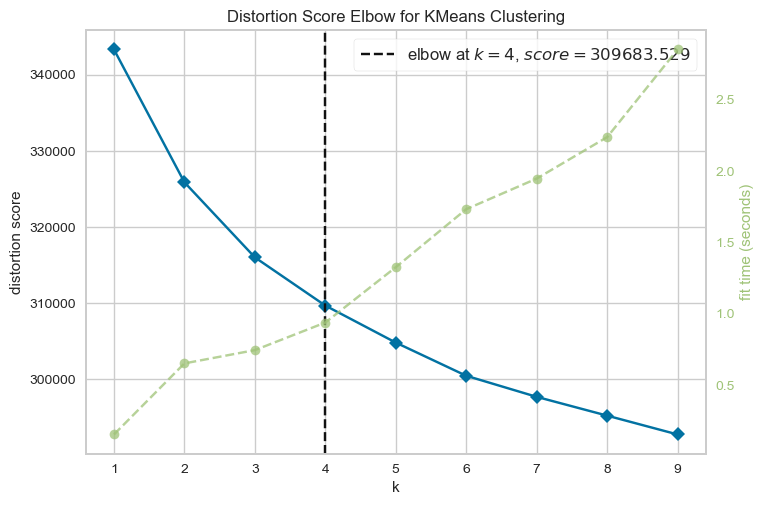

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [30]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))

visualizer.fit(embeddings)
visualizer.show()

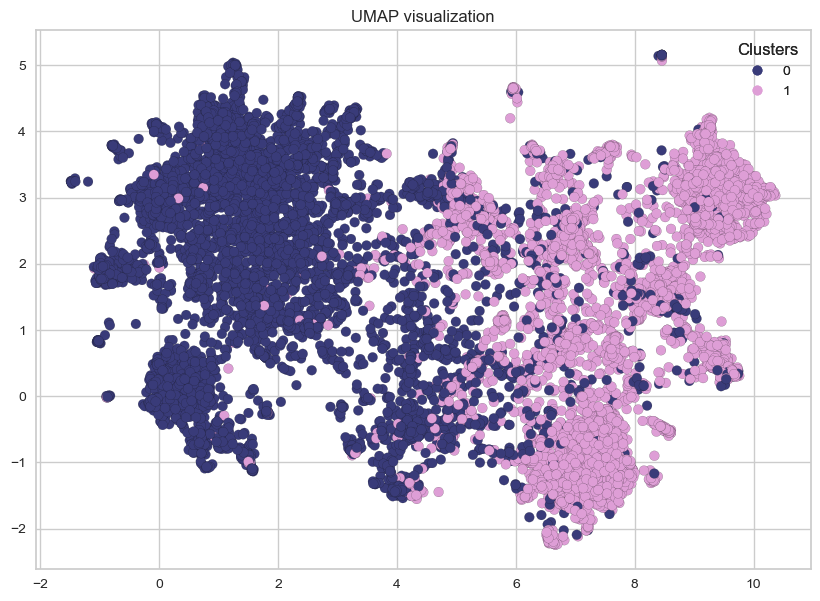

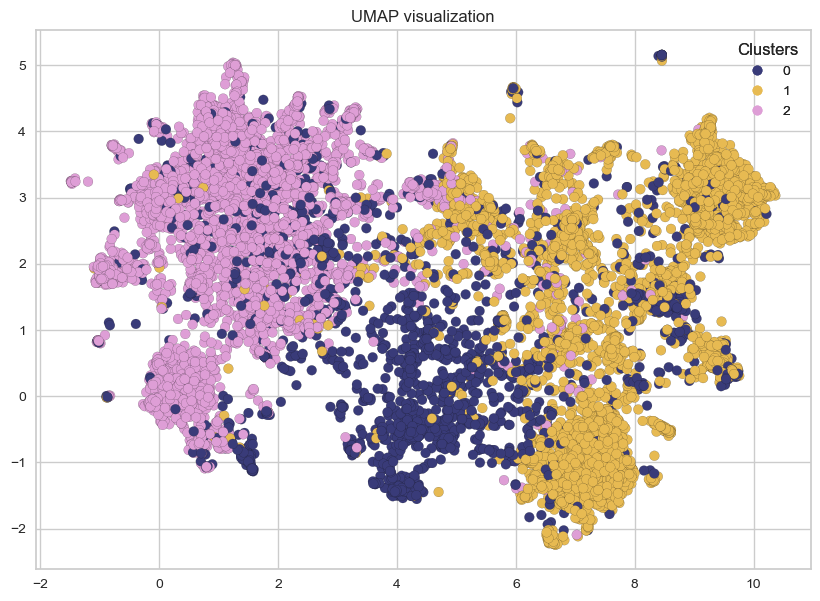

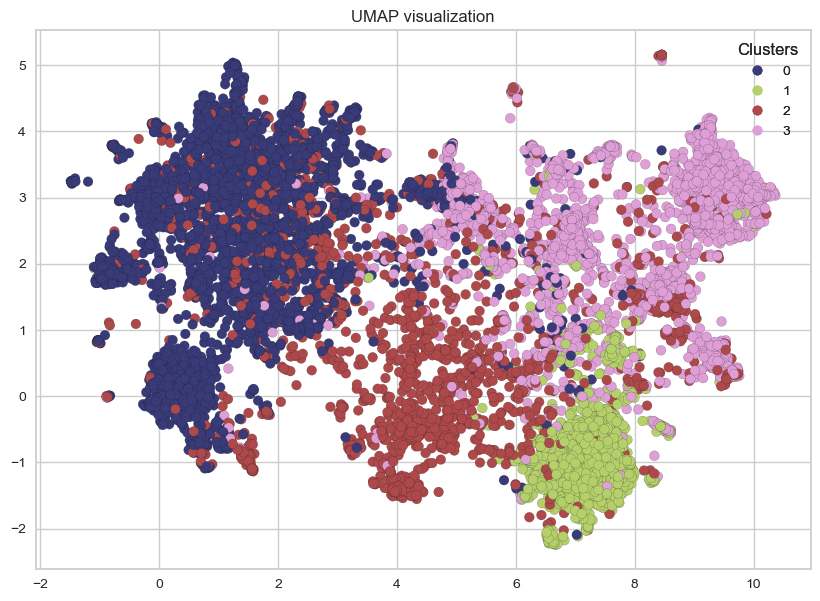

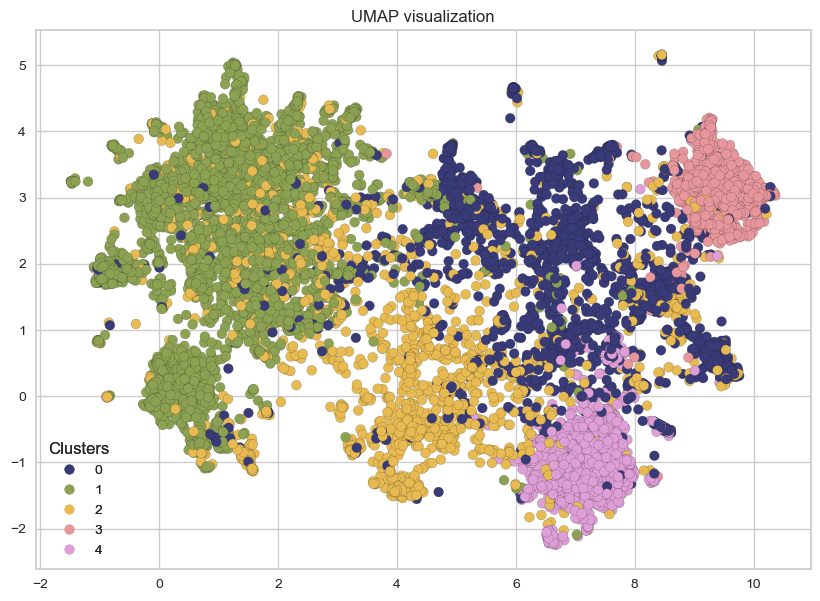

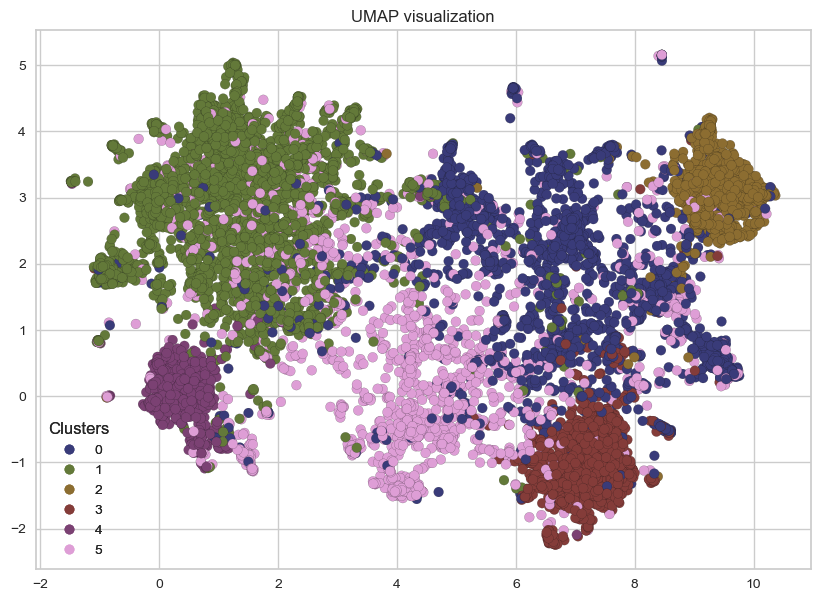

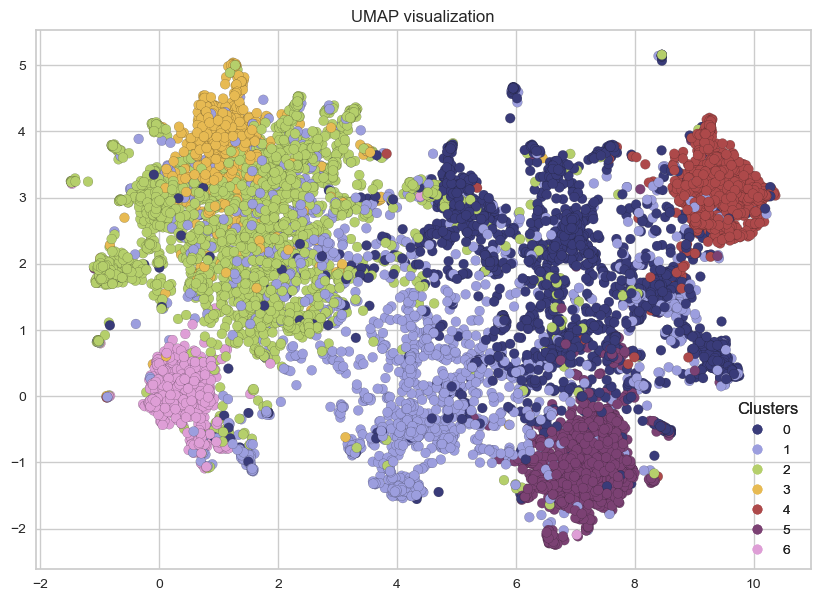

In [31]:
for i in range(2, 8):
    km = KMeans(n_clusters=i, random_state=42)
    km_pred = km.fit_predict(embeddings)
    plot_umap_clusters(embeddings, km_pred, raw_sents=recipes_df["name"])

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 3.2 Discussion 
rubric={points:4}

**Your tasks:** 
1. Comment on your results from 3.1. Are the plots above useful in narrowing down the range of values for `n_clusters`? Based on these visualizations, what value or a range of values seems reasonable for `n_clusters` in this problem? 

<div class="alert alert-warning">

Solution_3.2
    
</div>

_Points:_ 4

Yes, the plots were very useful in narrowing down the range.  According to the yellowbrick graph, 4 is the ideal n_clusters, but 5-7 seem very viable too as they provide a significant enough decrease to the distortion score. From the umap plots, it seems that a range of [4, 6] is reasonable, but 6 seems to be ideal as it captures the best distinction between clusters.

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 3.3 Sampling recipe names from clusters
rubric={points:5}

It's likely that with the methods in the previous exercises you did not get a satisfactory answer on how many clusters should be appropriate for this problem. One of the most important steps in clustering is manual interpretation of clusters. In this exercise, you will examine some samples from different clusters given by K-Means, which might give you a better understanding on the number of clusters and whether the clusters make sense or not.  

**Your tasks:**
1. Based on your answer in Exercise 3.1 and 3.2, pick one or two reasonable values for `n_clusters` and train `KMeans` with those values and `random_state=42`. 
2. Sample some examples (e.g., 10 to 15 recipe names) from each cluster and show the sampled recipes for each cluster. 

<div class="alert alert-warning">

Solution_3.3
    
</div>

_Points:_ 5

In [32]:
km = KMeans(n_clusters=6, random_state=42)
km_labels = km.fit_predict(embeddings)
km_labels

array([0, 0, 2, ..., 1, 5, 4])

In [33]:
clusters_df = pd.DataFrame({'recipe_name': recipes_df["name"].tolist(), 'cluster_label': km_labels})
clusters_df

,recipe_name,cluster_label
0,i yam what i yam muffins,0
1,to your health muffins,0
2,250 00 chocolate chip cookies,2
3,lplermagronen,5
4,california roll salad,4
...,...,...
9095,zucchini wheat germ cookies,2
9096,zucchini blueberry bread,0
9097,zucchini salsa burgers,1
9098,zuppa toscana,5


In [34]:
for cluster_label in range(6):
    samples = clusters_df[clusters_df['cluster_label'] == cluster_label].sample(15, random_state=42)
    print(f"Samples from cluster {cluster_label}:")
    for name in samples['recipe_name']:
        print(name)
    print()

Samples from cluster 0:
moroccan coconut fudge zucre coco
cinnamon sugar muffins
nana s oatmeal pancakes
italian olive bread
almond cheesecake brownies
instant potato bread  bread machine
creamy mushroom and almond pasta
chewy  fudgy triple chocolate brownies
ricotta pineapple muffins
delicious milk and honey bread   2 loaves
golden raisin rosemary muffins
emily s easy peanut butter bars
eggnog crepes
blackberry   orange iced tea
earl grey tea muffins

Samples from cluster 1:
chicken and camembert parcels
lemon chicken fettuccine with snow peas
soy ginger salmon with napa sesame slaw
mexican rice and bean soup
greek deviled eggs
honey   mustard glazed parsnips
grilled chicken  arugula  blue cheese pizza
sharon s baked brie
enchilada sauce best ever
oven fried drumsticks
venetian fish soup
twice baked potatoes with caramelized shallots
cabernet braised beef short ribs
old school meets new    cheesy  onion  spicy  bbq burger
curried beef  indonesia

Samples from cluster 2:
peanut butter 

<!-- BEGIN QUESTION -->

### 3.4 Manual interpretation of clusters
rubric={points:5}

**Your tasks:**
1. Do you see a clear distinction between clusters? What topics/themes do to see in different clusters? 

<div class="alert alert-warning">

Solution_3.4
    
</div>

_Points:_ 5

Yes, there is a clear distinction between clusters.
- Cluster 0: baked goods
- Cluster 1: proteins
- Cluster 2: cookies
- Cluster 3: cake
- Cluster 4: salad
- Cluster 5: drinks

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 3.5 Dendrogram
rubric={points:3}

**Your tasks:**

1. Show a dendrogram with `p=10` and `truncate_mode=level` on sentence embeddings of recipes with average linkage and `metric="cosine"`.
2. Briefly comment on the results.

> *Note: Try orientation="left" of `dendrogram` for better readability of the dendrogram.*

<div class="alert alert-warning">

Solution_3.5
    
</div>

_Points:_ 3

_Type your answer here, replacing this text._

In [35]:
from scipy.cluster.hierarchy import dendrogram, average, linkage
from sklearn.metrics import pairwise_distances

distances = pairwise_distances(embeddings, metric="cosine")
Z = linkage(distances, method="average")
Z



C:\Users\ryanm\AppData\Local\Temp\ipykernel_34756\1050009507.py:5: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distances, method="average")


array([[2.03300000e+03, 2.12700000e+03, 7.08265620e-01, 2.00000000e+00],
       [2.04000000e+03, 2.15900000e+03, 8.71733084e-01, 2.00000000e+00],
       [6.22000000e+02, 6.42000000e+02, 1.01886647e+00, 2.00000000e+00],
       ...,
       [1.81890000e+04, 1.81950000e+04, 1.48745221e+01, 7.75800000e+03],
       [1.79950000e+04, 1.81920000e+04, 1.56254588e+01, 1.34200000e+03],
       [1.81960000e+04, 1.81970000e+04, 1.84789165e+01, 9.10000000e+03]])

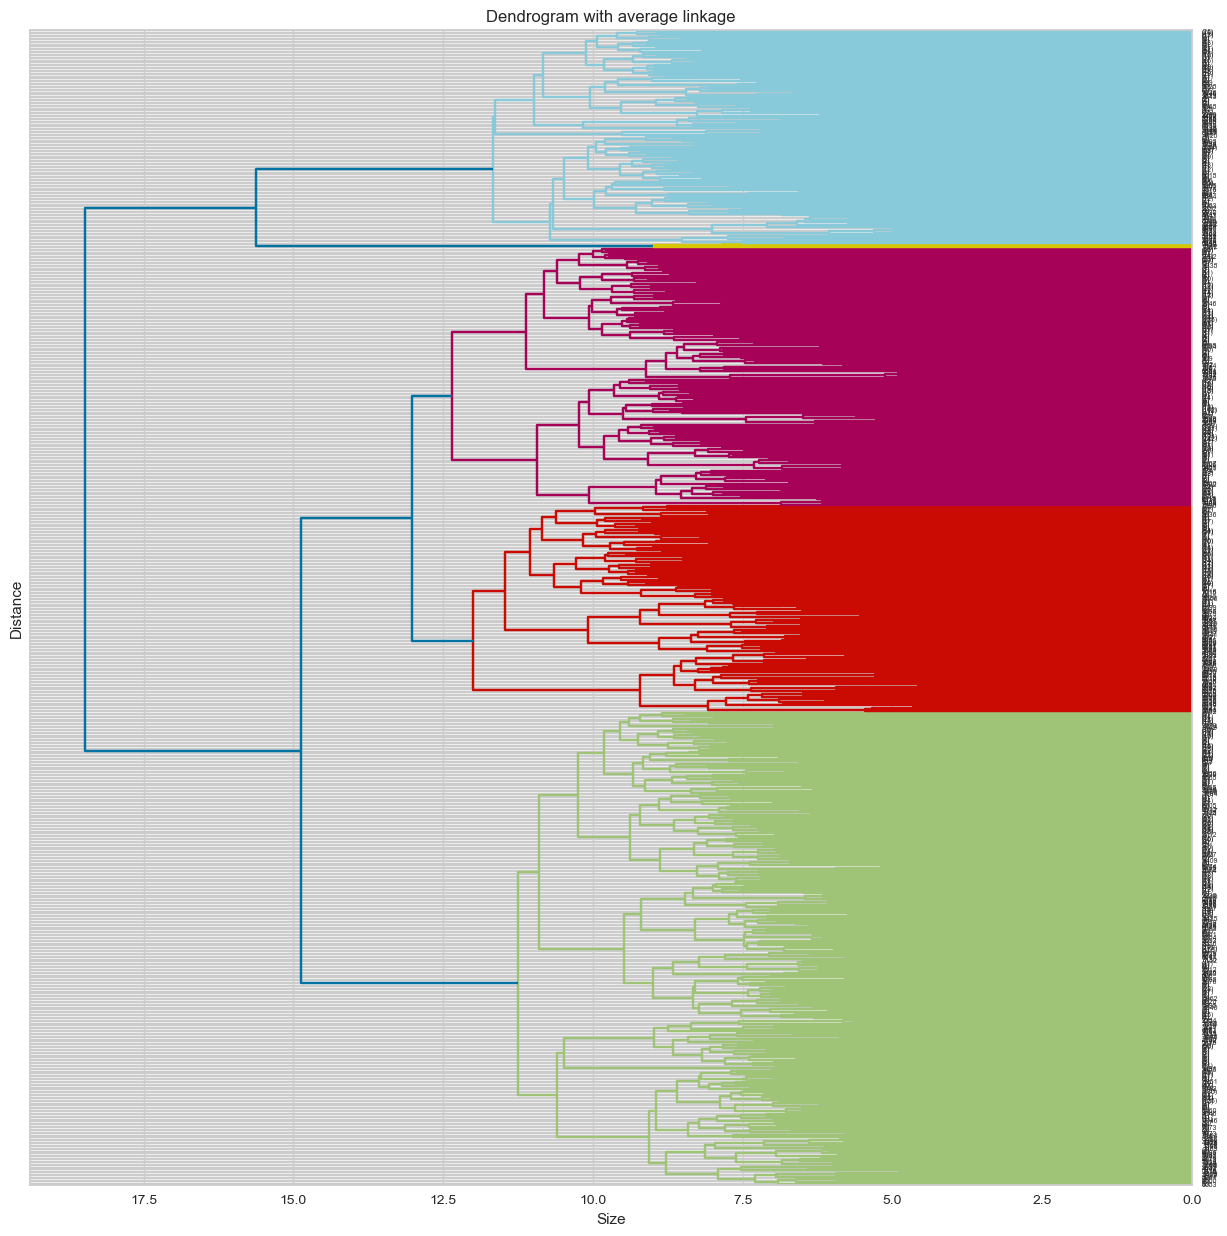

In [36]:
plt.figure(figsize=(15, 15))
dendrogram(Z, p=10, truncate_mode="level", orientation="left")
plt.title("Dendrogram with average linkage")
plt.xlabel("Size")
plt.ylabel("Distance")
plt.show()

The clusters are quite distinct and seem to roughly match the KMeans plot in terms of relative sizes, with the exception of the tiny yellow cluster.  Overall it seems to be a good representation of the data.

<!-- END QUESTION -->

<br><br><br><br>

**PLEASE READ BEFORE YOU SUBMIT:** 

When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from "1" will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 
4. Make sure that the plots and output are rendered properly in your submitted file. If the .ipynb file is too big and doesn't render on Gradescope, also upload a pdf or html in addition to the .ipynb so that the TAs can view your submission on Gradescope. 

![](img/eva-well-done.png)